In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [57]:
covid_data = pd.read_csv("data/covidData.csv")
covid_data

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,14/12/2020,14,12,2020,746,6,Afghanistan,AF,AFG,38041757.0,Asia,9.013779
1,13/12/2020,13,12,2020,298,9,Afghanistan,AF,AFG,38041757.0,Asia,7.052776
2,12/12/2020,12,12,2020,113,11,Afghanistan,AF,AFG,38041757.0,Asia,6.868768
3,11/12/2020,11,12,2020,63,10,Afghanistan,AF,AFG,38041757.0,Asia,7.134266
4,10/12/2020,10,12,2020,202,16,Afghanistan,AF,AFG,38041757.0,Asia,6.968658
...,...,...,...,...,...,...,...,...,...,...,...,...
61895,25/03/2020,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
61896,24/03/2020,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
61897,23/03/2020,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN
61898,22/03/2020,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14645473.0,Africa,NaN


In [58]:
data = covid_data[covid_data['countryterritoryCode'] == 'USA'][['dateRep','cases']]
data['dateRep'] = pd.to_datetime(data['dateRep'], format="%d/%m/%Y")
data = data.sort_values(by="dateRep", key=pd.to_datetime)
data = data.set_index('dateRep')
data

,cases
dateRep,
2019-12-31,0
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
...,...
2020-12-10,220025
2020-12-11,224680
2020-12-12,234633


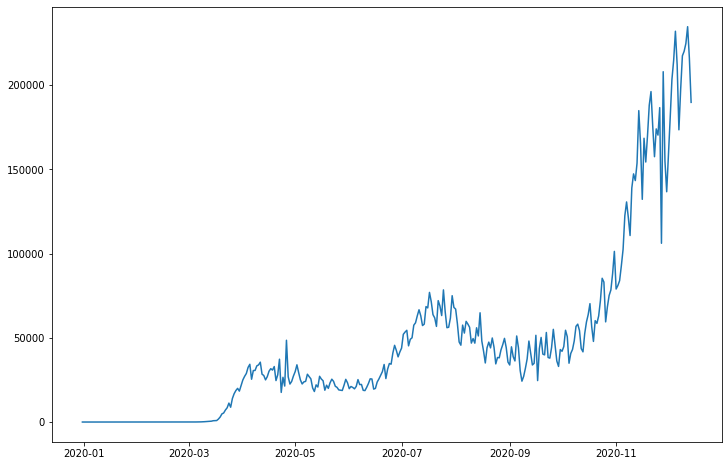

In [59]:
fig = plt.gcf().set_size_inches(12,8)
plt.plot(data, label = 'Covid-19 cases in the US')
plt.show()

In [60]:
def chunkify(data, seq_length):
    chunks = []
    targets = []
    
    for i in range (len(data)-seq_length-1):
        chunks.append(data[i:(i+seq_length)])
        targets.append(data[i+seq_length])
    
    return np.array(chunks),np.array(targets)

chunkify([[1],[2],[3],[4],[5],[6]],3)

(array([[[1],
         [2],
         [3]],
 
        [[2],
         [3],
         [4]]]),
 array([[4],
        [5]]))

In [129]:
sc = MinMaxScaler()
training_data = sc.fit_transform(data.values.copy())

seq_length = 5
x,y = chunkify(training_data, seq_length)

train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

In [130]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [131]:
class CovidPrediction(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(CovidPrediction, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fully_connected = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        ula, (h_out, _) = self.lstm(x, (h0, c0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fully_connected(h_out)
        return out

In [132]:
model = CovidPrediction(1,1,4,1)
print(model)

CovidPrediction(
  (lstm): LSTM(1, 4, batch_first=True)
  (fully_connected): Linear(in_features=4, out_features=1, bias=True)
)


In [204]:
num_epochs = 10000
learning_rate = 0.00001

model = CovidPrediction(1, 1, 6, 1)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = model(trainX)
    loss = criterion(outputs, trainY)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Iteration: %d, loss: %f" % (epoch, loss.item()))

Iteration: 0, loss: 0.219238
Iteration: 100, loss: 0.215330
Iteration: 200, loss: 0.210723
Iteration: 300, loss: 0.206056
Iteration: 400, loss: 0.201408
Iteration: 500, loss: 0.196803
Iteration: 600, loss: 0.192250
Iteration: 700, loss: 0.187753
Iteration: 800, loss: 0.183313
Iteration: 900, loss: 0.178932
Iteration: 1000, loss: 0.174607
Iteration: 1100, loss: 0.170340
Iteration: 1200, loss: 0.166129
Iteration: 1300, loss: 0.161973
Iteration: 1400, loss: 0.157872
Iteration: 1500, loss: 0.153823
Iteration: 1600, loss: 0.149826
Iteration: 1700, loss: 0.145880
Iteration: 1800, loss: 0.141983
Iteration: 1900, loss: 0.138134
Iteration: 2000, loss: 0.134332
Iteration: 2100, loss: 0.130573
Iteration: 2200, loss: 0.126857
Iteration: 2300, loss: 0.123181
Iteration: 2400, loss: 0.119542
Iteration: 2500, loss: 0.115938
Iteration: 2600, loss: 0.112366
Iteration: 2700, loss: 0.108824
Iteration: 2800, loss: 0.105312
Iteration: 2900, loss: 0.101830
Iteration: 3000, loss: 0.098380
Iteration: 3100, los

In [205]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
data_actual = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
data_actual = sc.inverse_transform(data_actual)

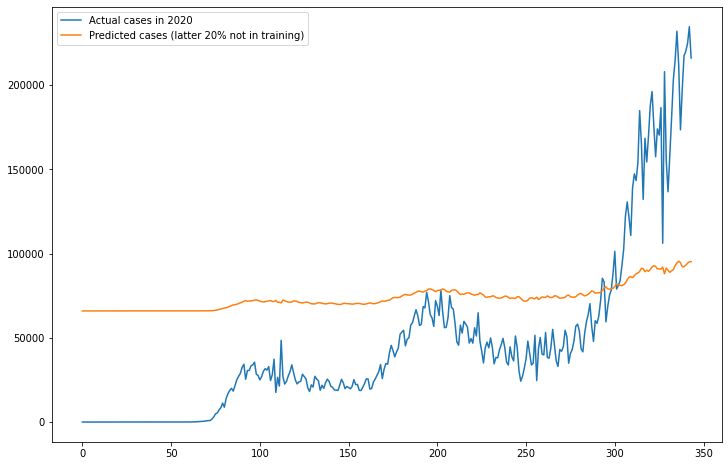

In [206]:
fig = plt.gcf().set_size_inches(12,8)
plt.plot(data_actual)
plt.plot(data_predict)
plt.suptitle('')
plt.legend(['Actual cases in 2020', 'Predicted cases (latter 20% not in training)'], loc='upper left')

In [207]:
data_predict

array([[65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.4  ],
       [65924.47 ],
       [65924.46 ],
       [65924.445],
       [65924.43 ],
       [65924.5  ],
       [65924.46 ],
       [65924.68 ],
       [65924.586],
       [65924.516],
       [65924.47 ],
       [65924.5  ],
       [65924.54 ],
       [65924.57 ],
       [65924.766],
       [65924.64 ],
       [65924.54 ],
       [65924.555],
       [65924.47 ],
       [65924.445],
       [65924.43 ],
       [65924.414],
       [65924.484],
       [65924.445],
       [65924.516],
       [65924.555],
       [65924.5  ],
       [65924.46 ],
       [65924.445],
       [65924.414],
       [65924.4  ],
       [65924.4  ],
       [65924.484],
       [65925.984],
